# GPT-4V Desktop Explorer

This notebook shows how to connect AgentDesk and GPT-4V. Please note that this example is simplified and doesn't intend to demonstrate how an agent may solve a task. To see our GUI surfing agent, please look at [SurfDino](https://github.com/agentsea/surfdino).

To run the full loop, execute this line:

```
poetry run python -m examples.gpt4v.main
```

Prerequisites:

* [qemu](https://www.qemu.org/)
* [Docker Desktop](https://www.docker.com/products/docker-desktop)
* `pip install agentdesk`

In [3]:
import getpass
import os

password = getpass.getpass("Enter your OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = password

In [4]:
import json

from examples.gpt4v.instruct import system_prompt, ActionSelection
from examples.gpt4v.oai import chat
from examples.gpt4v.util import visualize_b64_img, clean_llm_json
from agentdesk import Desktop

In [5]:
task = "Search for types of ducks in France"

In [6]:
# Create a local desktop
desktop = Desktop.local()

using ssh key in ~/.ssh/id_rsa.pub
waiting for desktop to be ready...
calling agentd...
agentd response:  <Response [200]>

successfully created desktop 'inspiring-albattani'
vm doesn't require proxy
connected to desktop via agentd


In [7]:
# Launch the desktop UI
desktop.view(background=True)

found running UI container


In [8]:
# Open Google on the desktop in Chrome
desktop.open_url("https://google.com")

In [9]:
# Get the actions a model can take on the desktop as json schema
actions = desktop.json_schema()
actions

[{'name': 'click',
  'parameters': {'type': 'object',
   'properties': {'button': {'type': 'string',
     'description': 'Button to click. Defaults to "left".'},
    'x': {'anyOf': [{'type': 'integer'}, {'type': 'null'}],
     'description': 'X coordinate to move to, if not provided it will click on current location. Defaults to None.'},
    'y': {'anyOf': [{'type': 'integer'}, {'type': 'null'}],
     'description': 'Y coordinate to move to, if not provided it will click on current location. Defaults to None.'}},
   'required': []},
  'description': 'Click mouse button'},
 {'name': 'double_click',
  'parameters': {'type': 'object', 'properties': {}, 'required': []},
  'description': 'Double click the mouse'},
 {'name': 'drag_mouse',
  'parameters': {'type': 'object',
   'properties': {'x': {'type': 'integer', 'description': 'x coordinate'},
    'y': {'type': 'integer', 'description': 'y coordinate'}},
   'required': ['x', 'y']},
  'description': 'Drag the mouse'},
 {'name': 'move_mouse

In [20]:
msgs = []

In [21]:
# Function calling not yet supported in GPT-4V so lets hack it in
msg =  {
        "role": "system",
        "content": [{"type": "text", "text": system_prompt(actions, {"x": 1280, "y": 1024})}],
}
msgs.append(msg)



In [22]:
response = chat(msgs)
msgs.append(response)
response

{'role': 'assistant',
 'content': "I'm ready. Please send the current screenshot and mouse coordinates."}

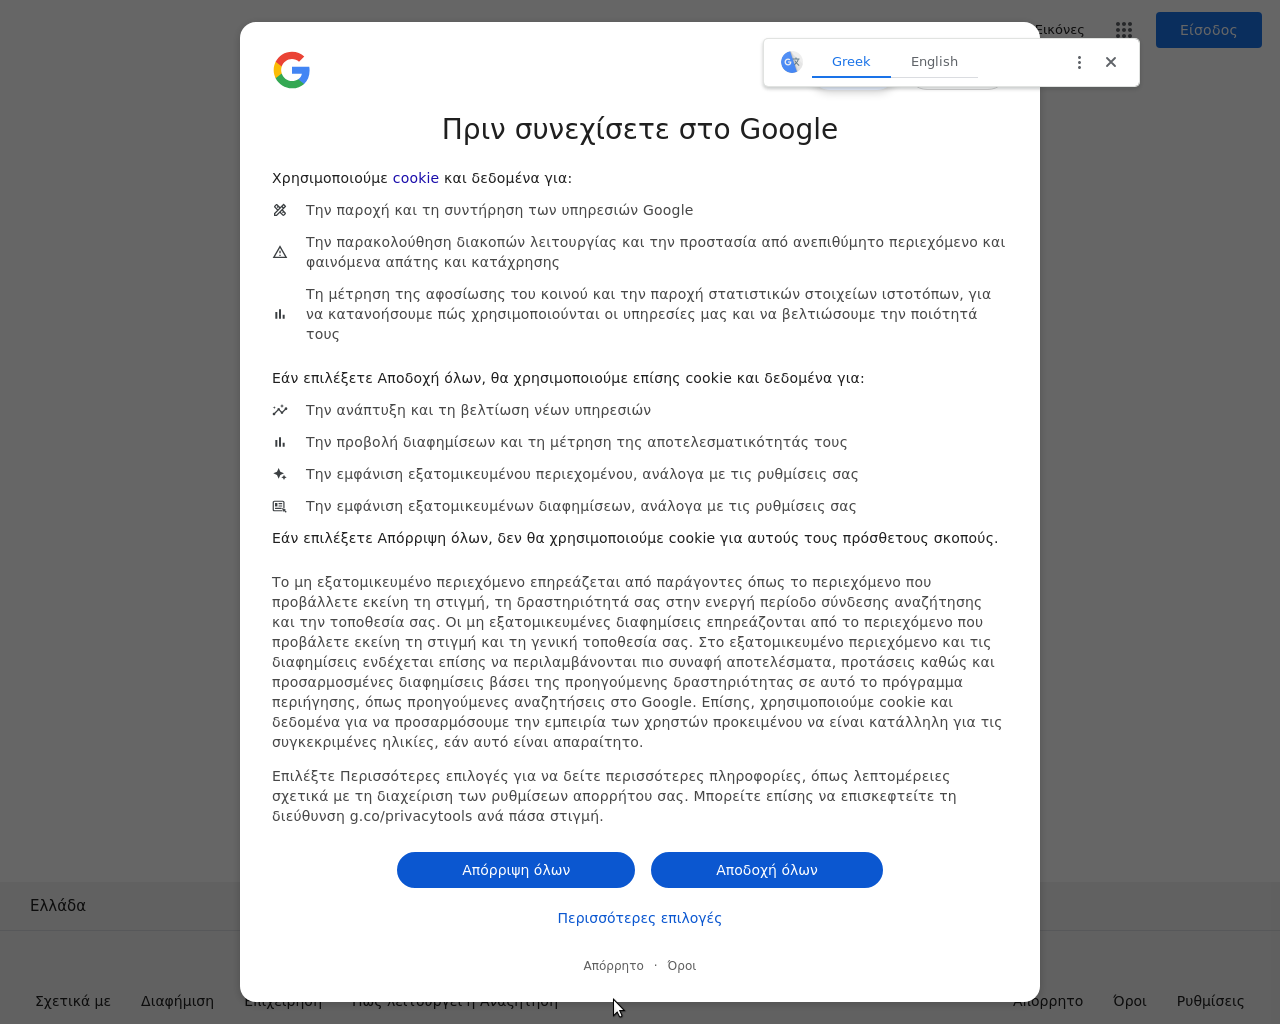

In [23]:
b64_img = desktop.take_screenshot()
visualize_b64_img(b64_img)

In [24]:
x, y = desktop.mouse_coordinates()
(x, y)

(614, 1000)

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are using a computer, you have access to a mouse and keyboard.\nI\'m going to show you the picture of the screen along with the current mouse coordinates.I will also give you another picture of the screen with a grid overlaying it where each square is 100px by 100px,the coordinates of each line intersection are written below it. You can use that to better guage how to move.\nThe screen size is (1280, 1024)\n\nWe will then select from a set of actions:\n\n[\n    {\n        "name": "click",\n        "parameters": {\n            "type": "object",\n            "properties": {\n                "button": {\n                    "type": "string",\n                    "description": "Button to click. Defaults to \\"left\\"."\n                },\n                "x": {\n                    "anyOf": [\n                        {\n                            "type": "integer"\n                        },\n                        {\n
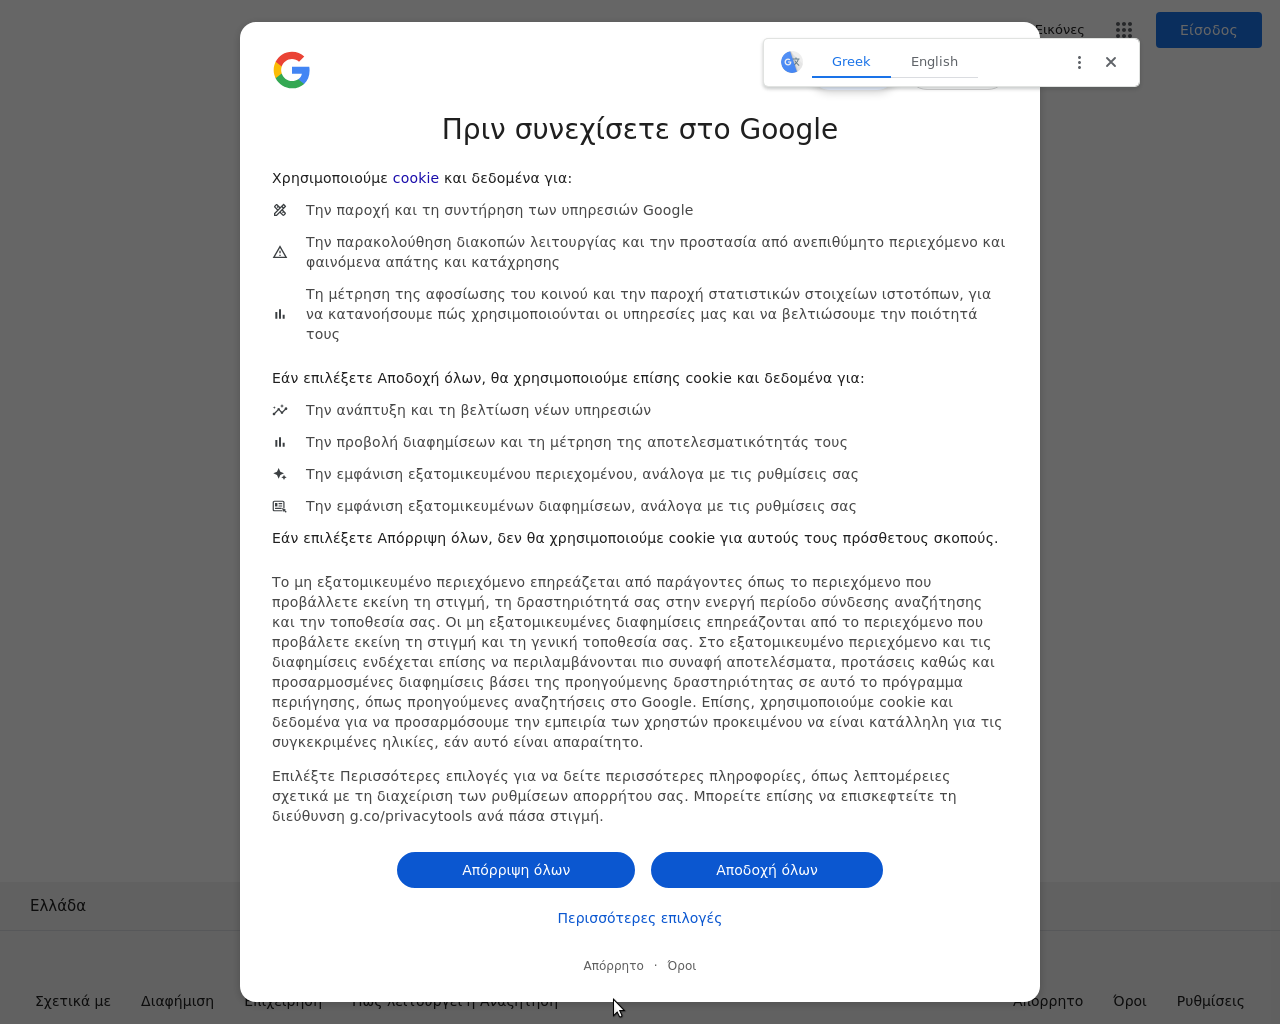

In [25]:
msg = {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": f"Current mouse coordinates are ({x}, {y}), and the task to solve is '{task}', please return the appropriate next action"
        },
        {
          "type": "image_url",
          "image_url": {
              "url": f"data:image/png;base64,{b64_img}"
          }
        }
      ],
}
msgs.append(msg)
msgs

In [26]:
response = chat(msgs)
response

{'role': 'assistant',
 'content': '{\n    "reason": "I need to click on the search bar to type the search query",\n    "action": {\n        "name": "click",\n        "parameters": {\n            "button": "left",\n            "x": 600,\n            "y": 450\n        }\n    }\n}'}

In [27]:
msgs.append(response)

In [28]:
# Parse our action out from GPT response
clean_content = clean_llm_json(response["content"])
jdict = json.loads(clean_content)
print("response dict: ", jdict)

selection = ActionSelection(**jdict)
print("action selection: ", selection)

response dict:  {'reason': 'I need to click on the search bar to type the search query', 'action': {'name': 'click', 'parameters': {'button': 'left', 'x': 600, 'y': 450}}}
action selection:  reason='I need to click on the search bar to type the search query' action=Action(name='click', parameters={'button': 'left', 'x': 600, 'y': 450})


In [29]:
if selection.action.name == "finished":
    print("task is finished")

In [30]:
action = desktop.find_action(selection.action.name)
print("found action: ", action)
if not action:
    print("action returned not found: ", selection.action.name)
    raise SystemError("action not found")

found action:  <opentool.base.Action object at 0x10a256c60>


In [31]:
response = desktop.use(action, **selection.action.parameters)

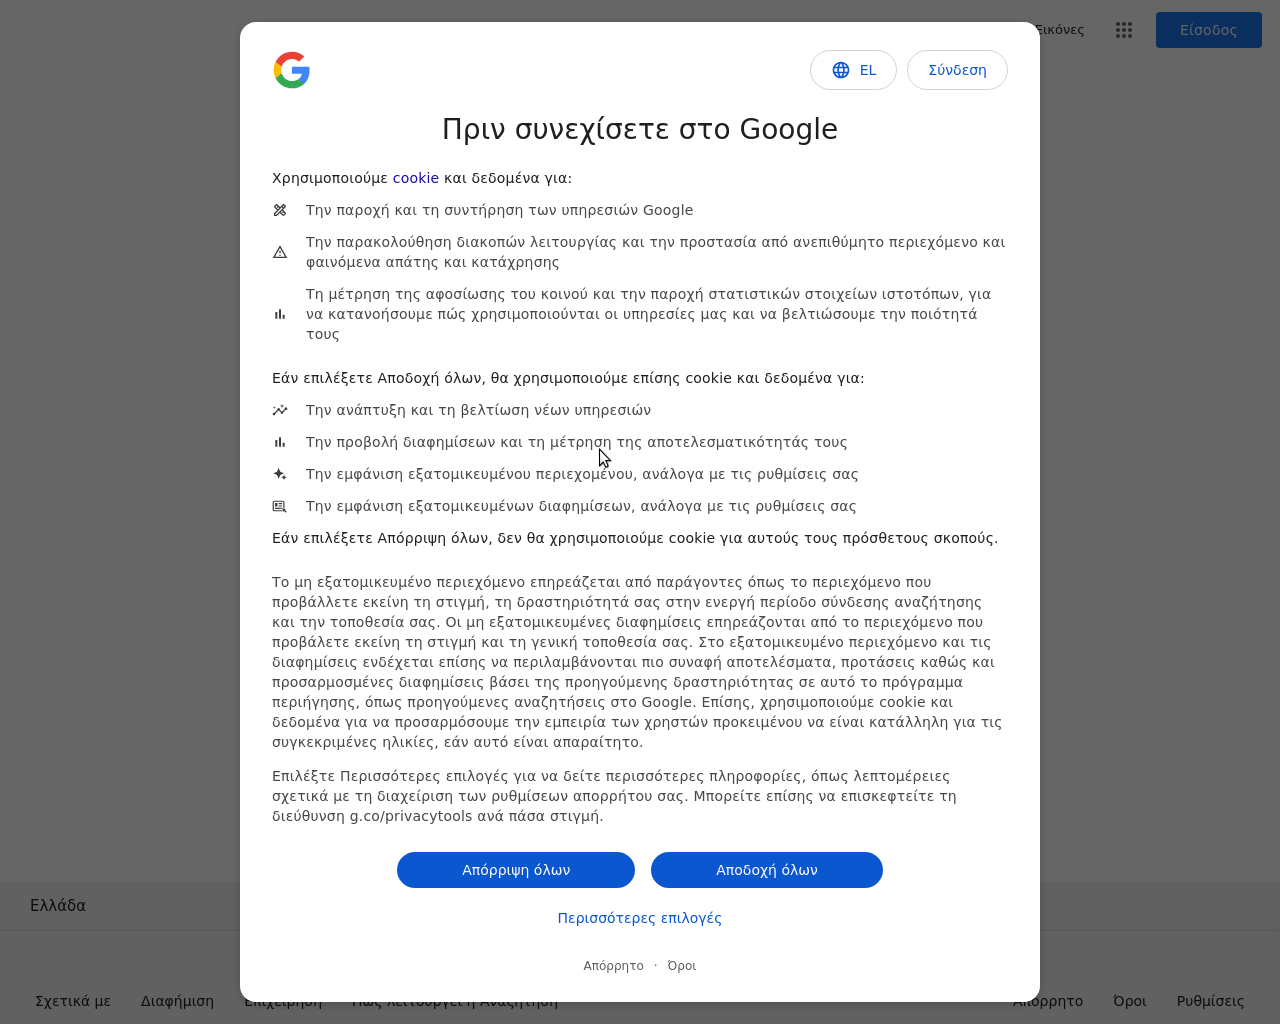

In [32]:
b64_img = desktop.take_screenshot()
visualize_b64_img(b64_img)

### What's next?

* Look at [agent.py](https://github.com/agentsea/agentdesk/blob/main/agentdesk/examples/gpt4v/agent.py) for the full code.
* Visit [our API reference](https://agentsea.github.io/agentdesk/).
* To see a more complex use-case, check out [SurfDino](https://github.com/agentsea/surfdino) – our GUI surfing agent.

